In [ ]:
import torch
import torch.nn.functional as F
from ts_inverse.attack_time_series_utils import SMAPELoss


def mape_multidimensional(input, target):
    """
    Compute the mean absolute percentage error (MAPE) for multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The MAPE value.
    """
    # Avoid division by zero
    epsilon = 1e-8
    # Calculate absolute percentage errors for each signal
    absolute_percentage_errors = torch.abs((target - input) / (target + epsilon))
    # Compute mean across all signals and time points
    mape = 100.0 * torch.mean(absolute_percentage_errors, dim=0)
    return mape


def signal_to_noise_ratio(input, target):
    """
    Compute the signal-to-noise ratio (SNR) for multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The SNR value.
    """
    target_mean = torch.mean(target, dim=0)
    target_var = torch.var(target, dim=0)
    error_mean = torch.mean(target - input, dim=0)
    error_var = torch.var(target - input, dim=0)
    snr = 10.0 * torch.log10((target_var + 1e-8) / (error_var + 1e-8))
    return snr


def pearson_correlation_coefficient(input, target):
    """
    Compute the Pearson correlation coefficient (PCC) for multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The PCC value.
    """
    input_mean = torch.mean(input, dim=0)
    target_mean = torch.mean(target, dim=0)
    input_std = torch.std(input, dim=0)
    target_std = torch.std(target, dim=0)
    pcc = torch.mean((input - input_mean) * (target - target_mean) / ((input_std + 1e-8) * (target_std + 1e-8)), dim=0)
    return pcc


def euclidean_distance(input, target):
    """
    Compute the Euclidean distance for multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The Euclidean distance.
    """
    euclidean_distance = torch.sqrt(torch.sum((input - target) ** 2, dim=0))
    return euclidean_distance / torch.sqrt(torch.tensor(input.size(0)))


def dynamic_time_warping(input, target):
    """
    Compute the dynamic time warping (DTW) for each signal in multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The DTW values for each signal.
    """
    # Initialize a tensor to store the DTW values for each signal
    n_signals = input.size(1)
    dtw_values = torch.zeros(n_signals)

    # Compute the DTW for each signal
    for signal_idx in range(n_signals):
        # Extract the current signal from input and target
        input_signal = input[:, signal_idx]
        target_signal = target[:, signal_idx]

        # Get the sizes of the input and target sequences for this signal
        n, m = input_signal.size(0), target_signal.size(0)

        # Create a matrix to hold the distances
        dtw_matrix = torch.full((n + 1, m + 1), float("inf"))
        dtw_matrix[0, 0] = 0

        # Compute the DTW
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = (input_signal[i - 1] - target_signal[j - 1]).abs()
                dtw_matrix[i, j] = cost + min(
                    dtw_matrix[i - 1, j],  # insertion
                    dtw_matrix[i, j - 1],  # deletion
                    dtw_matrix[i - 1, j - 1],
                )  # match

        # Store the DTW value for this signal
        dtw_values[signal_idx] = dtw_matrix[n, m]

    return dtw_values


def cosine_similarity(input, target):
    """
    Compute the cosine similarity for multidimensional time-series data.

    Args:
    input (torch.Tensor): The predicted values with shape (seq_length, n_signals).
    target (torch.Tensor): The ground truth values with shape (seq_length, n_signals).

    Returns:
    torch.Tensor: The cosine similarity for each signal.
    """
    input_norm = torch.norm(input, dim=0)
    target_norm = torch.norm(target, dim=0)
    cosine_similarity = torch.sum(input * target, dim=0) / (input_norm * target_norm + 1e-8)
    return cosine_similarity


def evaluate_metrics(seq_length=10):
    # For a time-series all 3 signals should have similar value, as the noise ratio is the same for each.
    signal_1 = torch.arange(seq_length).float()
    signal_2 = torch.ones(seq_length).float()
    signal_3 = torch.zeros(seq_length).float()
    signal_4 = torch.arange(seq_length).float().flip(0)
    signal_5 = torch.sin(torch.linspace(0, 2 * 3.14, seq_length)).float()
    signal_6 = torch.ones(seq_length).float() * 50
    signal = torch.stack((signal_1, signal_2, signal_3, signal_4, signal_5, signal_6), dim=1)

    torch.manual_seed(0)
    noise_1 = torch.randn_like(signal_1)
    noise = torch.stack([noise_1 * 100 for i in range(signal.shape[1])], dim=1)  # Same noise for all 3 signals
    # noise = torch.stack([noise_1 * (10**-i) for i in range(signal.shape[1])], dim=1) # Different noise for each signal
    noisey_signal = signal + noise

    # Plot the signals and the noisy signals
    print("arange, ones, zeros, flip, sin, ones*50, noise*0.1")

    # print(f"MAPE: {mape_multidimensional(noisey_signal, signal)}")
    print(f"MAE: {torch.mean(torch.abs(noisey_signal - signal), dim=0)}")
    # print(f"SNR: {signal_to_noise_ratio(noisey_signal, signal)}")
    # print(f"PCC: {pearson_correlation_coefficient(noisey_signal, signal)}")
    # print(f"Euclidean Distance: {euclidean_distance(noisey_signal, signal)}")
    # print(f"RMSE: {torch.sqrt(F.mse_loss(noisey_signal, signal))}")
    # # print(f"DTW: {dynamic_time_warping(noisey_signal, signal)}")
    # print(f"Cosine Similarity: {cosine_similarity(noisey_signal, signal)}")

    print(f"SMAPE: {SMAPELoss(noisey_signal, signal)}")
    print()


evaluate_metrics(seq_length=10)
evaluate_metrics(seq_length=1000)
evaluate_metrics(seq_length=10000)


arange, ones, zeros, flip, sin, ones*50, noise*0.1
MAE: tensor([94.2874, 94.2874, 94.2874, 94.2874, 94.2874, 94.2874])
SMAPE: 1.8570698499679565

arange, ones, zeros, flip, sin, ones*50, noise*0.1
MAE: tensor([80.8697, 80.8697, 80.8697, 80.8697, 80.8697, 80.8697])
SMAPE: 1.2755820751190186

arange, ones, zeros, flip, sin, ones*50, noise*0.1
MAE: tensor([79.7088, 79.7087, 79.7087, 79.7087, 79.7087, 79.7087])
SMAPE: 1.1877018213272095



In [ ]:
import pandas as pd
import datetime
from ts_inverse.datahandler import ElectricityDataSet
import matplotlib.pyplot as plt
import torch
import numpy as np

df_electricity_370 = pd.read_csv("../data/Electricity370/LD2011_2014_first_40_consumers.csv", index_col="Time", parse_dates=["Time"])
df_electricity_370.head()

series = df_electricity_370.loc[:, df_electricity_370.columns[0]]

el_dataset = ElectricityDataSet(
    series, step_size=datetime.timedelta(hours=24), observation_length=datetime.timedelta(days=1), target_length=datetime.timedelta(days=1)
)

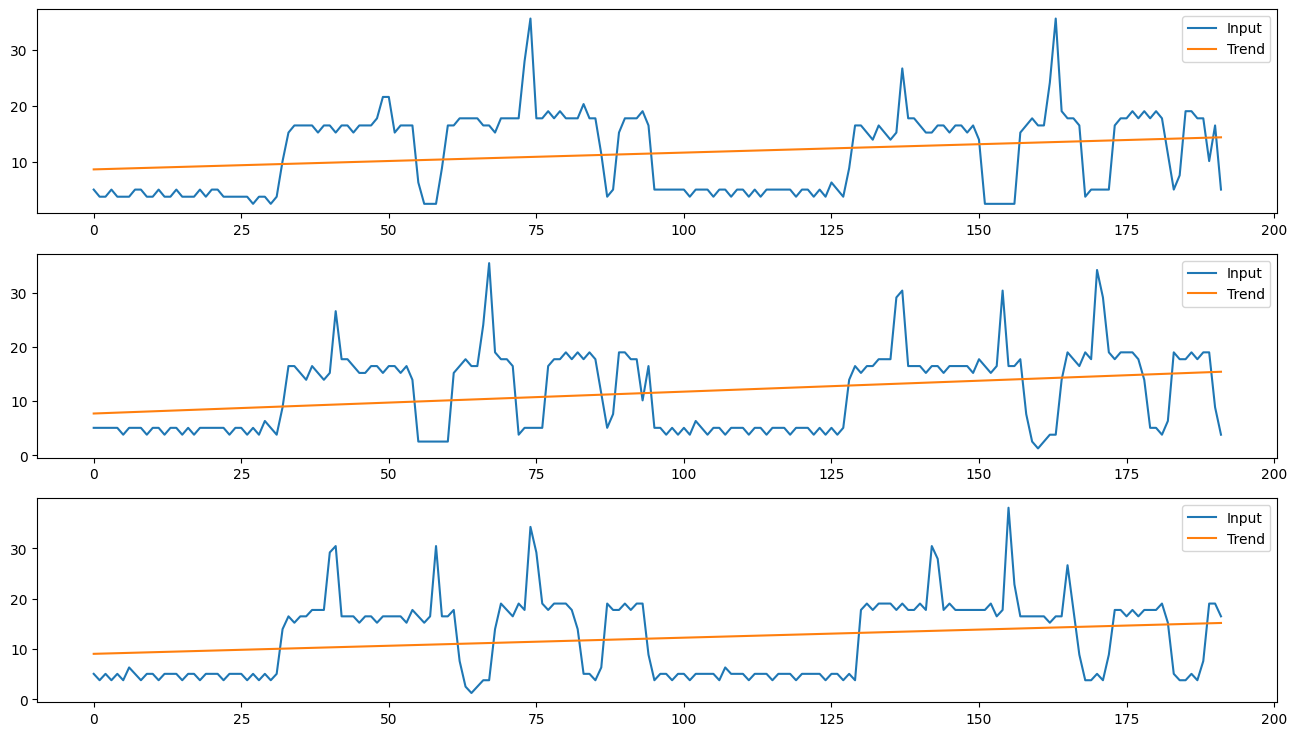

In [ ]:
# Capturing trend:


def get_sequence_trend(sequence):
    """
    Computes the linear trend of a sequence using linear regression.
    Args:
        sequence (torch.Tensor): Tensor of shape (batch_size, sequence_length).
    Returns:
        trend (torch.Tensor): Tensor of the same shape as input, representing the linear trend.
    """
    # Calculate time indices
    time = torch.arange(sequence.shape[1], dtype=sequence.dtype, device=sequence.device).view(1, -1)

    # Calculate the means of time and sequence
    time_mean = time.mean()
    sequence_mean = sequence.mean(dim=1, keepdim=True)

    # Compute the slope (beta) of the linear trend
    beta = ((time - time_mean) * (sequence - sequence_mean)).sum(dim=1, keepdim=True) / ((time - time_mean) ** 2).sum()

    # Compute the trend
    trend = beta * (time - time_mean) + sequence_mean

    return trend


inputs, targets = el_dataset[6:9]
inputs, targets = inputs[:, :, 0], targets[:, :, 0]
combined = torch.cat((inputs, targets), dim=1)
batch_size, inputs_sequence_length = inputs.shape

fig, axes = plt.subplots(batch_size, 1, figsize=(16, 3 * batch_size))
axes = np.atleast_1d(axes)  # Ensure axes is always an array for consistency
for i, ax in enumerate(axes):
    ax.plot(combined[i].cpu().numpy(), label="Input")
    ax.plot(get_sequence_trend(combined[i].unsqueeze(0)).squeeze().cpu().numpy(), label="Trend")
    ax.legend()


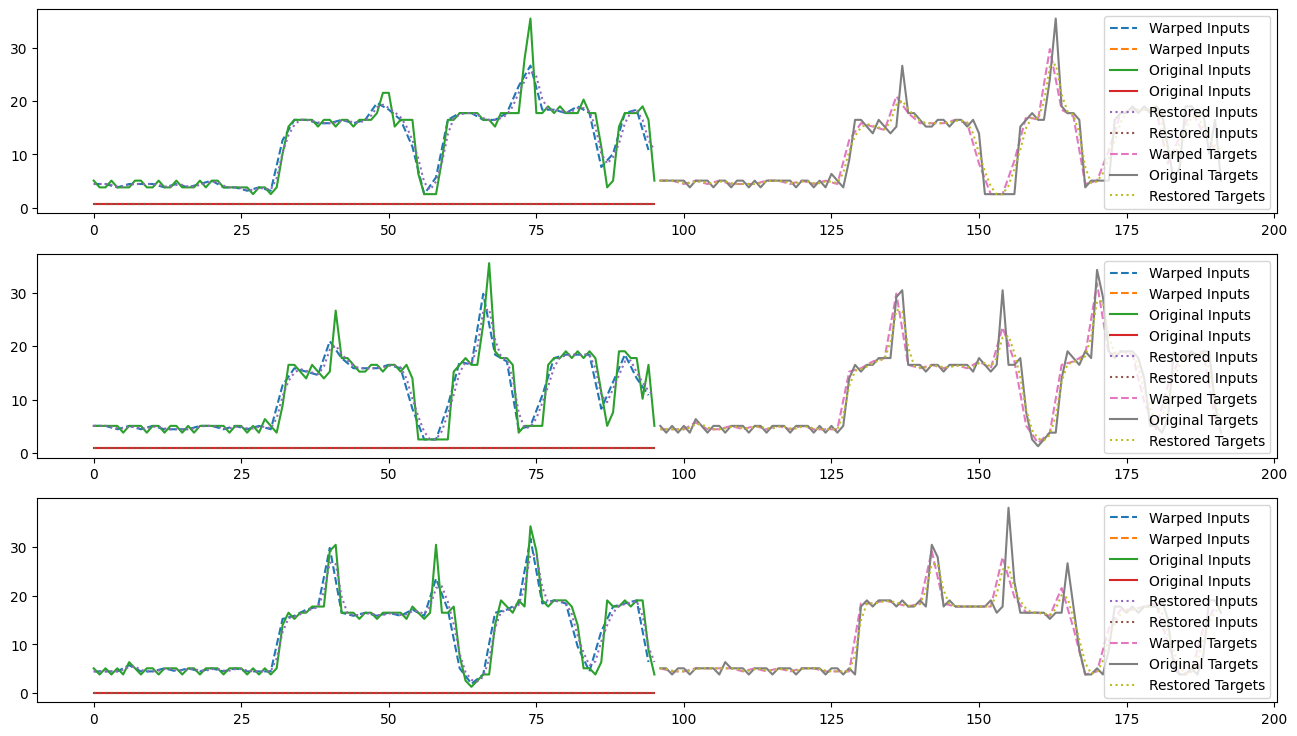

In [ ]:
import numpy as np
from ts_inverse.attack_time_series_utils import temporal_resolution_warping, interpolate

# Example time series data
inputs, targets = el_dataset[6:9]

inputs, targets = inputs[:, :, [0, 2]], targets[:, :, 0]
batch_size, inputs_sequence_length, inputs_n_features = inputs.shape
_, targets_sequence_length = targets.shape

res_factor = 2

warped_inputs = temporal_resolution_warping(inputs, res_factor)
restored_inputs = interpolate(warped_inputs, inputs_sequence_length)

warped_targets = temporal_resolution_warping(targets.unsqueeze(-1), res_factor)
restored_targets = interpolate(warped_targets, targets.shape[1]).squeeze(-1)

# Plotting the original, warped, and restored data for comparison
fig, axes = plt.subplots(batch_size, 1, figsize=(16, 3 * batch_size))
axes = np.atleast_1d(axes)  # Ensure axes is always an array for consistency
for i, ax in enumerate(axes):
    warped_x_axis = np.linspace(0, inputs_sequence_length + targets_sequence_length - 2, num=warped_inputs.shape[1] + warped_targets.shape[1])
    original_x_axis = np.arange(inputs_sequence_length + targets_sequence_length)
    ax.plot(warped_x_axis[: warped_inputs.shape[1]], warped_inputs[i].detach().cpu().numpy(), label="Warped Inputs", linestyle="--")
    ax.plot(original_x_axis[:inputs_sequence_length], inputs[i].detach().cpu().numpy(), label="Original Inputs")
    ax.plot(original_x_axis[:inputs_sequence_length], restored_inputs[i].detach().cpu().numpy(), label="Restored Inputs", linestyle=":")

    ax.plot(warped_x_axis[-warped_targets.shape[1] :], warped_targets[i].detach().cpu().numpy(), label="Warped Targets", linestyle="--")
    ax.plot(original_x_axis[-targets_sequence_length:], targets[i].detach().cpu().numpy(), label="Original Targets")
    ax.plot(original_x_axis[-targets_sequence_length:], restored_targets[i].detach().cpu().numpy(), label="Restored Targets", linestyle=":")
    ax.legend()
plt.show()

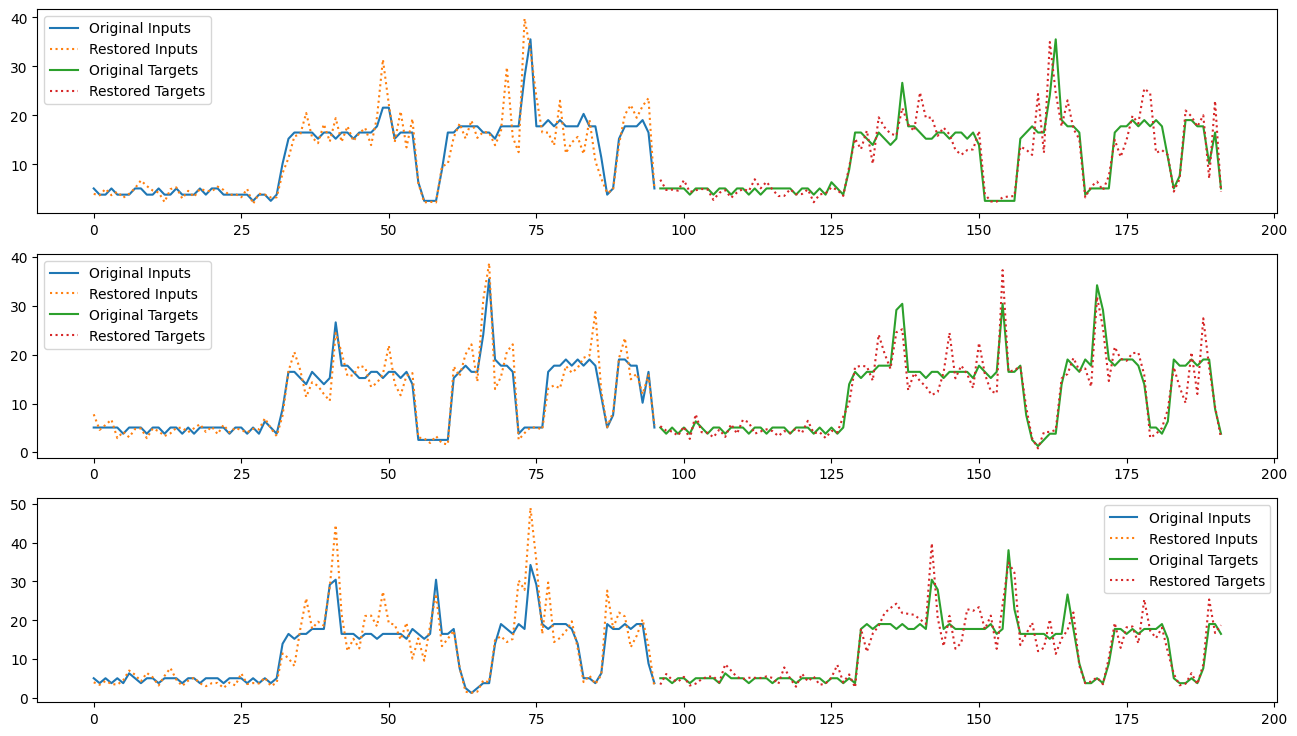

In [ ]:
import numpy as np
import torch.fft as fft


def input_augmentation(X, inputaug):
    if inputaug == "raw":
        return X

    if inputaug == "LPF":
        X_f = fft.rfft(X, dim=-1)
        msk = torch.ones_like(X_f)
        msk[:, :, int(msk.shape[-1] * 0.5) :] = 0

        # Check if mask has any non-zero elements
        if not torch.any(msk):
            return X  # Return original data if mask is empty

        X_f = X_f * msk
        X = fft.irfft(X_f, dim=-1)
        return X.real

    if inputaug == "FTPP":
        perturbation_factor = torch.pi / 10
        fft_data = fft.fft(X)
        phase_perturbation = torch.randn_like(fft_data) * perturbation_factor
        perturbed_fft_data = torch.abs(fft_data) * torch.exp(1j * (torch.angle(fft_data) + phase_perturbation))
        perturbed_data = fft.ifft(perturbed_fft_data).real
        return perturbed_data
    if inputaug == "FTMP":
        perturbation_factor = 0.01
        fft_data = fft.fft(X)
        amplitude = torch.abs(fft_data)
        for c in range(amplitude.shape[1]):
            target = torch.mean(amplitude[:, c, 1:])
            # noise = torch.randn_like(amplitude) * perturbation_factor * target
            noise = torch.randn_like(amplitude[:, c, :]) * perturbation_factor * target
            amplitude[:, c, :] = amplitude[:, c, :] + noise
        perturbed_fft_data = amplitude * torch.exp(1j * torch.angle(fft_data))
        perturbed_data = fft.ifft(perturbed_fft_data).real
        return perturbed_data


# Example time series data
inputs, targets = el_dataset[6:9]

inputs, targets = inputs[:, :, [0]], targets[:, :, [0]]
batch_size, inputs_sequence_length, inputs_n_features = inputs.shape
_, targets_sequence_length, _ = targets.shape

res_factor = 2

filtered_inputs = input_augmentation(inputs, "FTPP")
filtered_targets = input_augmentation(targets, "FTPP")

# Plotting the original, warped, and restored data for comparison
fig, axes = plt.subplots(batch_size, 1, figsize=(16, 3 * batch_size))
axes = np.atleast_1d(axes)  # Ensure axes is always an array for consistency
for i, ax in enumerate(axes):
    warped_x_axis = np.linspace(0, inputs_sequence_length + targets_sequence_length - 2, num=warped_inputs.shape[1] + warped_targets.shape[1])
    original_x_axis = np.arange(inputs_sequence_length + targets_sequence_length)
    # ax.plot(warped_x_axis[:warped_inputs.shape[1]], warped_inputs[i].detach().cpu().numpy(), label='Warped Inputs', linestyle='--')
    ax.plot(original_x_axis[:inputs_sequence_length], inputs[i].detach().cpu().numpy(), label="Original Inputs")
    ax.plot(original_x_axis[:inputs_sequence_length], filtered_inputs[i].detach().cpu().numpy(), label="Restored Inputs", linestyle=":")

    # ax.plot(warped_x_axis[-warped_targets.shape[1]:], warped_targets[i].detach().cpu().numpy(), label='Warped Targets', linestyle='--')
    ax.plot(original_x_axis[-targets_sequence_length:], targets[i].detach().cpu().numpy(), label="Original Targets")
    ax.plot(original_x_axis[-targets_sequence_length:], filtered_targets[i].detach().cpu().numpy(), label="Restored Targets", linestyle=":")
    ax.legend()
plt.show()